In [101]:
'''Main'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip, datetime

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import Grid

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error

'''Algos'''
import lightgbm as lgb

'''TensorFlow and Keras'''
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda
from keras.layers import Embedding, Flatten, dot
from keras import regularizers
from keras.losses import mse, binary_crossentropy

In [24]:
# Load the datasets
current_path = os.getcwd()
file = '\\datasets\\mnist_data\\mnist.pkl.gz'
f = gzip.open(current_path+file, 'rb')
train_set, validation_set, test_set = pickle.load(f, encoding='latin1')
f.close()

X_train, y_train = train_set[0], train_set[1]
X_validation, y_validation = validation_set[0], validation_set[1]
X_test, y_test = test_set[0], test_set[1]

In [25]:
# Verify shape of datasets
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_validation: ", X_validation.shape)
print("Shape of y_validation: ", y_validation.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (50000, 784)
Shape of y_train:  (50000,)
Shape of X_validation:  (10000, 784)
Shape of y_validation:  (10000,)
Shape of X_test:  (10000, 784)
Shape of y_test:  (10000,)


In [26]:
# Create Pandas DataFrames from the datasets
train_index = range(0,len(X_train))
validation_index = range(len(X_train),len(X_train)+len(X_validation))
test_index = range(len(X_train)+len(X_validation), \
                   len(X_train)+len(X_validation)+len(X_test))

X_train = pd.DataFrame(data=X_train,index=train_index)
y_train = pd.Series(data=y_train,index=train_index)

X_validation = pd.DataFrame(data=X_validation,index=validation_index)
y_validation = pd.Series(data=y_validation,index=validation_index)

X_test = pd.DataFrame(data=X_test,index=test_index)
y_test = pd.Series(data=y_test,index=test_index)

In [27]:
# Describe the training matrix
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
count,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.0,50000.0,50000.0,50000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000739,0.000354,0.000204,0.000090,0.000071,0.000009,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.022778,0.015422,0.012079,0.007217,0.007181,0.001483,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.992188,0.992188,0.988281,0.988281,0.992188,0.242188,0.0,0.0,0.0,0.0


In [28]:
# Show the labels
y_train.head()

0    5
1    0
2    4
3    1
4    9
dtype: int64

In [29]:
def view_digit(X, y, example):
    label = y.loc[example]
    image = X.loc[example,:].values.reshape([28,28])
    plt.title('Example: %d  Label: %d' % (example, label))
    plt.imshow(image, cmap=plt.get_cmap('gray'))
    plt.show()

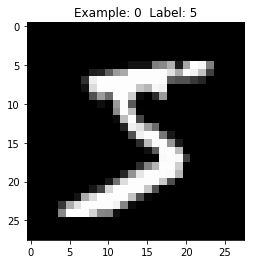

In [30]:
# View the first digit
view_digit(X_train, y_train, 0)

In [31]:
def one_hot(series):
    label_binarizer = pp.LabelBinarizer()
    label_binarizer.fit(range(max(series)+1))
    return label_binarizer.transform(series)

In [32]:
def reverse_one_hot(originalSeries, newSeries):
    label_binarizer = pp.LabelBinarizer()
    label_binarizer.fit(range(max(originalSeries)+1))
    return label_binarizer.inverse_transform(newSeries)

In [33]:
# Create one-hot vectors for the labels
y_train_oneHot = one_hot(y_train)
y_validation_oneHot = one_hot(y_validation)
y_test_oneHot = one_hot(y_test)

In [34]:
# Show one-hot vector for example 0, which is the number 5
y_train_oneHot[0]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [62]:
# Define RBM class
class RBM(object):
    
    def __init__(self, input_size, output_size, 
                 learning_rate, epochs, batchsize):
        # Define hyperparameters
        self._input_size = input_size
        self._output_size = output_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batchsize = batchsize
        
        # Initialize weights and biases using zero matrices
        self.w = np.zeros([input_size, output_size], dtype=np.float32)
        self.hb = np.zeros([output_size], dtype=np.float32)
        self.vb = np.zeros([input_size], dtype=np.float32)

    def prob_h_given_v(self, visible, w, hb):
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)

    def prob_v_given_h(self, hidden, w, vb):
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)
    
    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))

    def train(self, X):
        _w = tf.placeholder(tf.float32, [self._input_size, self._output_size])
        _hb = tf.placeholder(tf.float32, [self._output_size])
        _vb = tf.placeholder(tf.float32, [self._input_size])
        
        prv_w = np.zeros([self._input_size, self._output_size], dtype=np.float32)
        prv_hb = np.zeros([self._output_size], dtype=np.float32)
        prv_vb = np.zeros([self._input_size], dtype=np.float32)
        
        cur_w = np.zeros([self._input_size, self._output_size], dtype=np.float32)
        cur_hb = np.zeros([self._output_size], dtype=np.float32)
        cur_vb = np.zeros([self._input_size], dtype=np.float32)
        
        v0 = tf.placeholder(tf.float32, [None, self._input_size])
        h0 = self.sample_prob(self.prob_h_given_v(v0, _w, _hb))
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb))
        h1 = self.prob_h_given_v(v1, _w, _hb)
        
        positive_grad = tf.matmul(tf.transpose(v0), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)
        
        update_w = _w + self.learning_rate * \
            (positive_grad - negative_grad) / tf.to_float(tf.shape(v0)[0])
        update_vb = _vb +  self.learning_rate * tf.reduce_mean(v0 - v1, 0)
        update_hb = _hb +  self.learning_rate * tf.reduce_mean(h0 - h1, 0)
        
        err = tf.reduce_mean(tf.square(v0 - v1))
        
        error_list = []
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            
            for epoch in range(self.epochs):
                for start, end in zip(range(0, len(X), \
                        self.batchsize),range(self.batchsize,len(X), \
                                              self.batchsize)):
                    batch = X[start:end]
                    cur_w = sess.run(update_w, feed_dict={v0: batch, \
                                    _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_hb = sess.run(update_hb, feed_dict={v0: batch, \
                                    _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_vb = sess.run(update_vb, feed_dict={v0: batch, \
                                    _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                error = sess.run(err, feed_dict={v0: X, \
                                _w: cur_w, _vb: cur_vb, _hb: cur_hb})
                print ('Epoch: %d' % epoch,'reconstruction error: %f' % error)
                error_list.append(error)
            self.w = prv_w
            self.hb = prv_hb
            self.vb = prv_vb
            return error_list

    def rbm_output(self, X):
        
        input_X = tf.constant(X)
        _w = tf.constant(self.w)
        _hb = tf.constant(self.hb)
        _vb = tf.constant(self.vb)
        out = tf.nn.sigmoid(tf.matmul(input_X, _w) + _hb)
        hiddenGen = self.sample_prob(self.prob_h_given_v(input_X, _w, _hb))
        visibleGen = self.sample_prob(self.prob_v_given_h(hiddenGen, _w, _vb))
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            return sess.run(out), sess.run(visibleGen), sess.run(hiddenGen)
        
    def show_features(self, shape, suptitle, count=-1):
        maxw = np.amax(self.w.T)
        minw = np.amin(self.w.T)
        count = self._output_size if count == -1 or count > \
                self._output_size else count
        ncols = count if count < 14 else 14 
        nrows = count//ncols
        nrows = nrows if nrows > 2 else 3
        fig = plt.figure(figsize=(ncols, nrows), dpi=100)
        grid = Grid(fig, rect=111, nrows_ncols=(nrows, ncols), axes_pad=0.01)

        for i, ax in enumerate(grid):
            x = self.w.T[i] if i<self._input_size else np.zeros(shape)
            x = (x.reshape(1, -1) - minw)/maxw
            ax.imshow(x.reshape(*shape), cmap=mpl.cm.Greys)
            ax.set_axis_off()

        fig.text(0.5,1, suptitle, fontsize=20, horizontalalignment='center')
        fig.tight_layout()
        plt.show()
        return

In [67]:
# Since we are training, set input as training data
inputX = np.array(X_train)
inputX = inputX.astype(np.float32)

# Create list to hold our RBMs
rbm_list = []

# Define the parameters of the RBMs we will train
rbm_list.append(RBM(784,700,1.0,100,200))
rbm_list.append(RBM(700,600,1.0,100,200))
rbm_list.append(RBM(600,500,1.0,100,200))

In [68]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11349992173038295840
]


In [69]:
outputList = []
error_list = []
#For each RBM in our list
for i in range(0,len(rbm_list)):
    print('RBM', i+1)
    #Train a new one
    rbm = rbm_list[i]
    err = rbm.train(inputX)
    error_list.append(err)
    #Return the output layer
    outputX, reconstructedX, hiddenX = rbm.rbm_output(inputX)
    outputList.append(outputX)
    inputX = hiddenX

RBM 1
Epoch: 0 reconstruction error: 0.075924
Epoch: 1 reconstruction error: 0.065297
Epoch: 2 reconstruction error: 0.059989
Epoch: 3 reconstruction error: 0.055971
Epoch: 4 reconstruction error: 0.052860
Epoch: 5 reconstruction error: 0.050888
Epoch: 6 reconstruction error: 0.049374
Epoch: 7 reconstruction error: 0.048545
Epoch: 8 reconstruction error: 0.047555
Epoch: 9 reconstruction error: 0.046638
Epoch: 10 reconstruction error: 0.045534
Epoch: 11 reconstruction error: 0.045118
Epoch: 12 reconstruction error: 0.044242
Epoch: 13 reconstruction error: 0.044123
Epoch: 14 reconstruction error: 0.044215
Epoch: 15 reconstruction error: 0.043799
Epoch: 16 reconstruction error: 0.043111
Epoch: 17 reconstruction error: 0.042752
Epoch: 18 reconstruction error: 0.042900
Epoch: 19 reconstruction error: 0.042479
Epoch: 20 reconstruction error: 0.042163
Epoch: 21 reconstruction error: 0.042040
Epoch: 22 reconstruction error: 0.042250
Epoch: 23 reconstruction error: 0.041702
Epoch: 24 reconstruc

Epoch: 0 reconstruction error: 0.033191
Epoch: 1 reconstruction error: 0.027791
Epoch: 2 reconstruction error: 0.025368
Epoch: 3 reconstruction error: 0.023727
Epoch: 4 reconstruction error: 0.022622
Epoch: 5 reconstruction error: 0.022051
Epoch: 6 reconstruction error: 0.021293
Epoch: 7 reconstruction error: 0.020597
Epoch: 8 reconstruction error: 0.020206
Epoch: 9 reconstruction error: 0.019682
Epoch: 10 reconstruction error: 0.019452
Epoch: 11 reconstruction error: 0.019081
Epoch: 12 reconstruction error: 0.018940
Epoch: 13 reconstruction error: 0.018807
Epoch: 14 reconstruction error: 0.018381
Epoch: 15 reconstruction error: 0.018351
Epoch: 16 reconstruction error: 0.018078
Epoch: 17 reconstruction error: 0.018014
Epoch: 18 reconstruction error: 0.017686
Epoch: 19 reconstruction error: 0.017846
Epoch: 20 reconstruction error: 0.017562
Epoch: 21 reconstruction error: 0.017530
Epoch: 22 reconstruction error: 0.017483
Epoch: 23 reconstruction error: 0.017218
Epoch: 24 reconstruction e

RBM 1


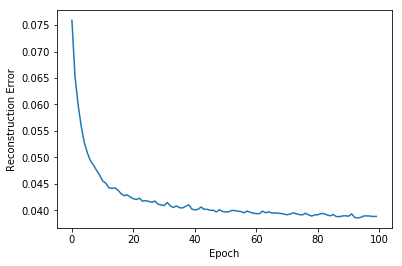

RBM 2


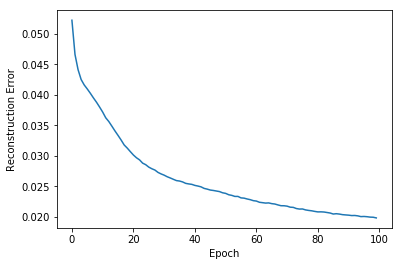

RBM 3


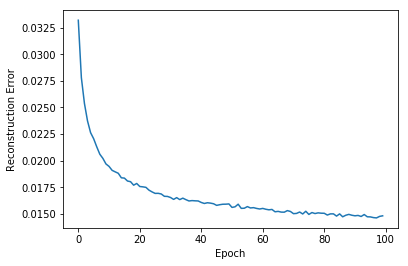

In [70]:
# Plot reconstruction errors
i = 1
for err in error_list:
    print("RBM",i)
    pd.Series(err).plot(logy=False)
    plt.xlabel("Epoch")
    plt.ylabel("Reconstruction Error")
    plt.show()
    i += 1

RBM 0


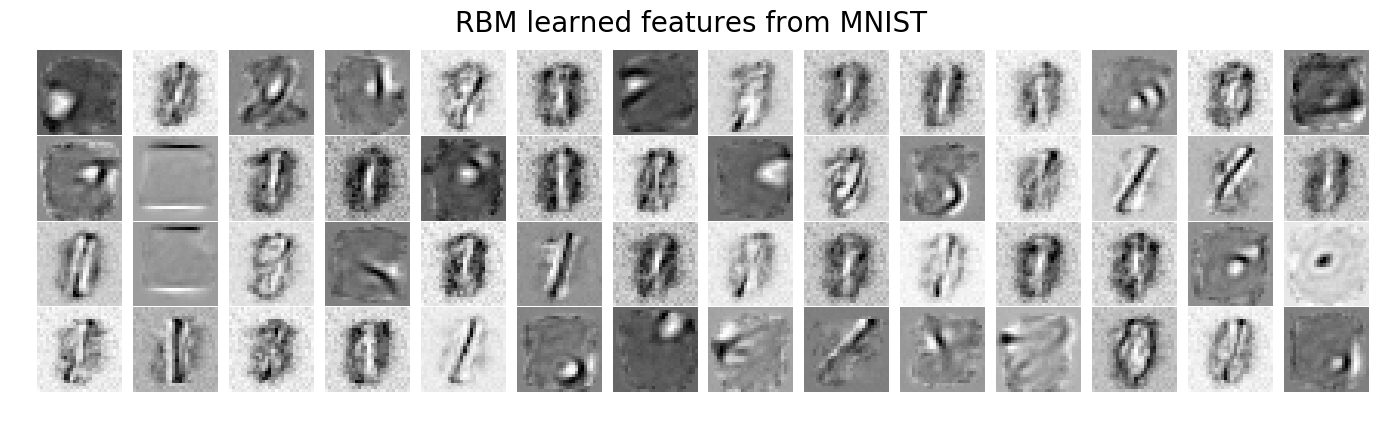

None
RBM 1


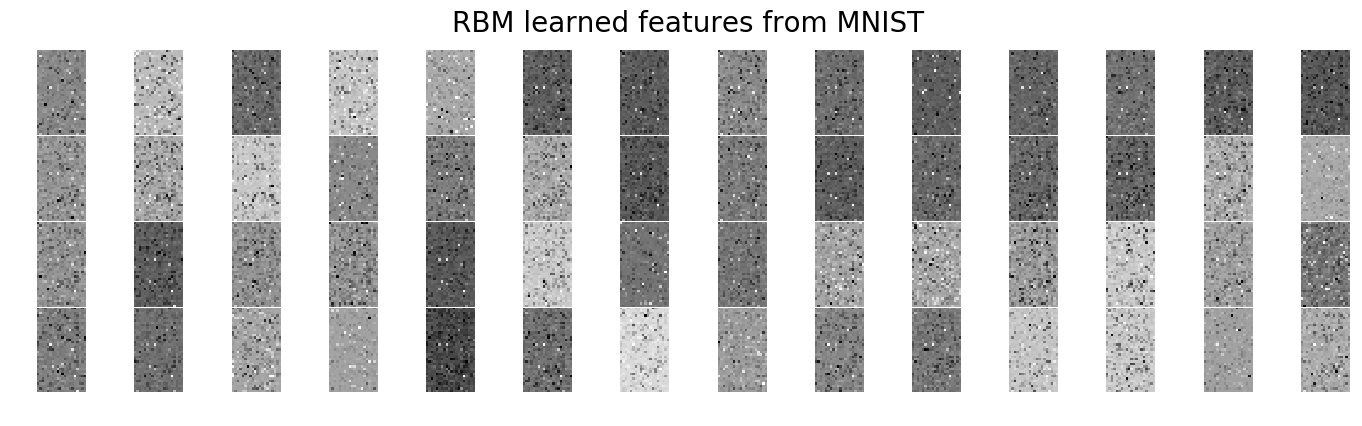

None
RBM 2


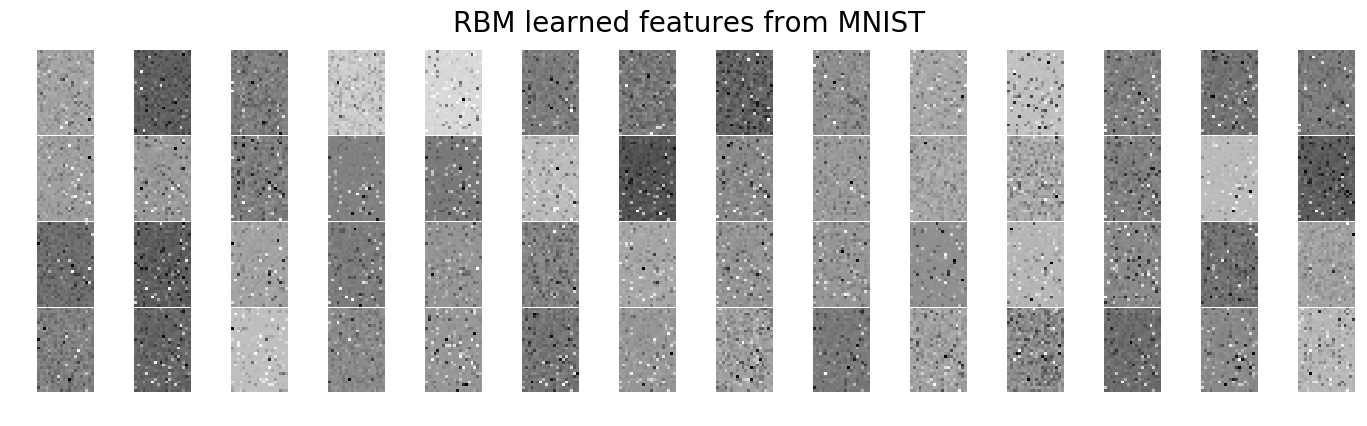

None


In [81]:
# Examine Feature Detectors
rbm_shapes = [(28,28),(35,20),(30,20)]
for i in range(0,len(rbm_list)):
    rbm = rbm_list[i]
    print("RBM",i)
    print(rbm.show_features(rbm_shapes[i], \
                            "RBM learned features from MNIST", 56))

RBM 1
Image generated by RBM


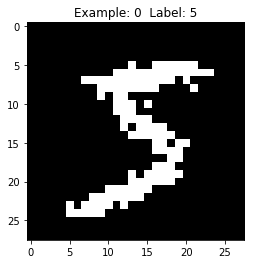

Original image


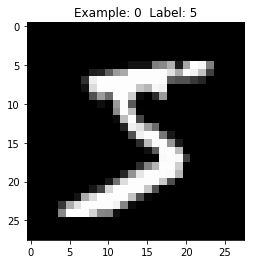

Image generated by RBM


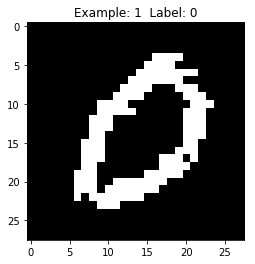

Original image


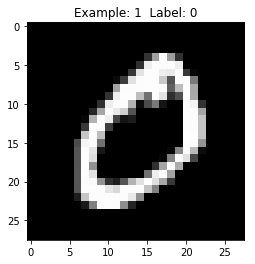

Image generated by RBM


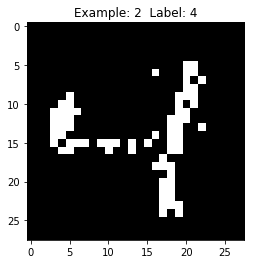

Original image


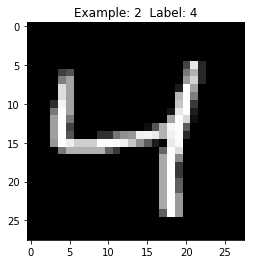

Image generated by RBM


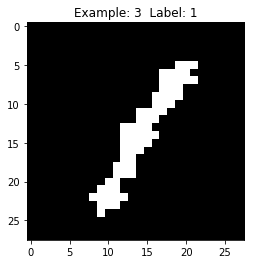

Original image


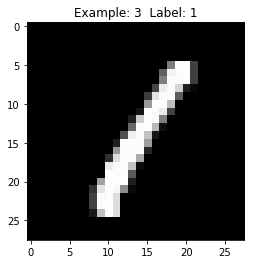

Image generated by RBM


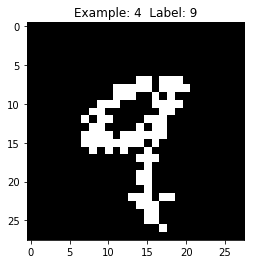

Original image


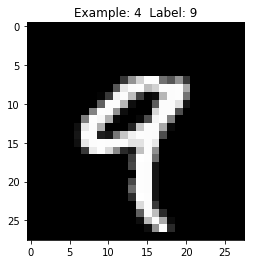

Image generated by RBM


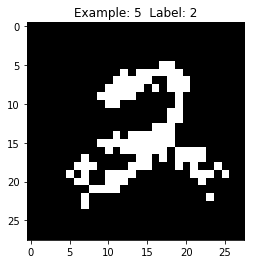

Original image


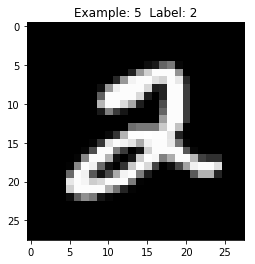

Image generated by RBM


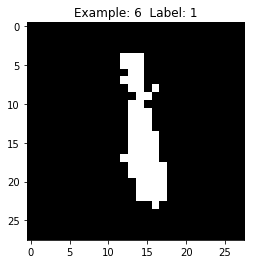

Original image


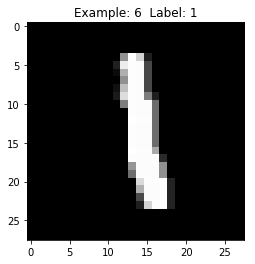

Image generated by RBM


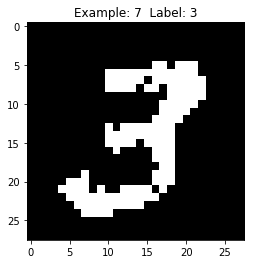

Original image


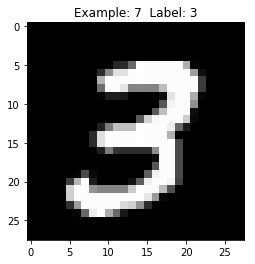

Image generated by RBM


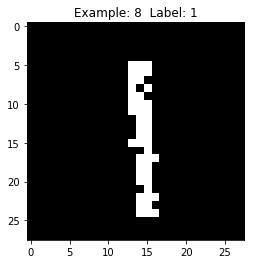

Original image


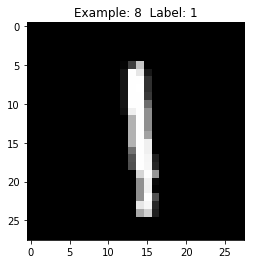

Image generated by RBM


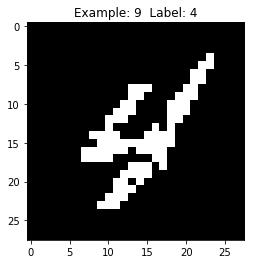

Original image


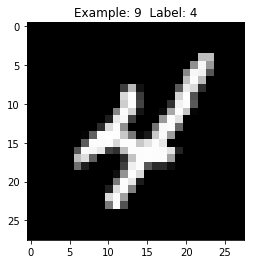

In [82]:
# View generated images from the first RBM
inputX = np.array(X_train)
rbmOne = rbm_list[0]

print('RBM 1')
outputX_rbmOne, reconstructedX_rbmOne, hiddenX_rbmOne = \
                            rbmOne.rbm_output(inputX)
reconstructedX_rbmOne = pd.DataFrame(data=reconstructedX_rbmOne, \
                                     index=X_train.index)
for j in range(0,10):
    example = j
    print("Image generated by RBM")
    view_digit(reconstructedX_rbmOne, y_train, example)
    print("Original image")
    view_digit(X_train, y_train, example)

In [84]:
class DBN(object):
    def __init__(self, original_input_size, input_size, output_size, 
                 learning_rate, epochs, batchsize, rbmOne, rbmTwo, rbmThree):
        # Define hyperparameters
        self._original_input_size = original_input_size
        self._input_size = input_size
        self._output_size = output_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batchsize = batchsize
        self.rbmOne = rbmOne
        self.rbmTwo = rbmTwo
        self.rbmThree = rbmThree
    
        self.w = np.zeros([input_size, output_size], "float")
        self.hb = np.zeros([output_size], "float")
        self.vb = np.zeros([input_size], "float")
    
    def prob_h_given_v(self, visible, w, hb):
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)

    def prob_v_given_h(self, hidden, w, vb):
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)
    
    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))

    def train(self, X):
        _w = tf.placeholder("float", [self._input_size, self._output_size])
        _hb = tf.placeholder("float", [self._output_size])
        _vb = tf.placeholder("float", [self._input_size])
        
        prv_w = np.zeros([self._input_size, self._output_size], "float")
        prv_hb = np.zeros([self._output_size], "float")
        prv_vb = np.zeros([self._input_size], "float")
        
        cur_w = np.zeros([self._input_size, self._output_size], "float")
        cur_hb = np.zeros([self._output_size], "float")
        cur_vb = np.zeros([self._input_size], "float")
        
        v0 = tf.placeholder("float", [None, self._original_input_size])

        forwardOne = tf.nn.relu(tf.sign(tf.nn.sigmoid(tf.matmul(v0, \
                        self.rbmOne.w) + self.rbmOne.hb) - tf.random_uniform( \
                        tf.shape(tf.nn.sigmoid(tf.matmul(v0, self.rbmOne.w) + \
                        self.rbmOne.hb)))))
        forwardTwo = tf.nn.relu(tf.sign(tf.nn.sigmoid(tf.matmul(forwardOne, \
                        self.rbmTwo.w) + self.rbmTwo.hb) - tf.random_uniform( \
                        tf.shape(tf.nn.sigmoid(tf.matmul(forwardOne, \
                        self.rbmTwo.w) + self.rbmTwo.hb)))))
        forward = tf.nn.relu(tf.sign(tf.nn.sigmoid(tf.matmul(forwardTwo, \
                        self.rbmThree.w) + self.rbmThree.hb) - \
                        tf.random_uniform(tf.shape(tf.nn.sigmoid(tf.matmul( \
                        forwardTwo, self.rbmThree.w) + self.rbmThree.hb)))))
        h0 = self.sample_prob(self.prob_h_given_v(forward, _w, _hb))
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb))
        h1 = self.prob_h_given_v(v1, _w, _hb)
        
        positive_grad = tf.matmul(tf.transpose(forward), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)
        
        update_w = _w + self.learning_rate * (positive_grad - negative_grad) / \
                        tf.to_float(tf.shape(forward)[0])
        update_vb = _vb +  self.learning_rate * tf.reduce_mean(forward - v1, 0)
        update_hb = _hb +  self.learning_rate * tf.reduce_mean(h0 - h1, 0)
        
        backwardOne = tf.nn.relu(tf.sign(tf.nn.sigmoid(tf.matmul(v1, \
                            self.rbmThree.w.T) + self.rbmThree.vb) - \
                            tf.random_uniform(tf.shape(tf.nn.sigmoid( \
                            tf.matmul(v1, self.rbmThree.w.T) + \
                            self.rbmThree.vb)))))
        backwardTwo = tf.nn.relu(tf.sign(tf.nn.sigmoid(tf.matmul(backwardOne, \
                            self.rbmTwo.w.T) + self.rbmTwo.vb) - \
                            tf.random_uniform(tf.shape(tf.nn.sigmoid( \
                            tf.matmul(backwardOne, self.rbmTwo.w.T) + \
                            self.rbmTwo.vb)))))
        backward = tf.nn.relu(tf.sign(tf.nn.sigmoid(tf.matmul(backwardTwo, \
                            self.rbmOne.w.T) + self.rbmOne.vb) - \
                            tf.random_uniform(tf.shape(tf.nn.sigmoid( \
                            tf.matmul(backwardTwo, self.rbmOne.w.T) + \
                            self.rbmOne.vb)))))
        
        err = tf.reduce_mean(tf.square(v0 - backward))
        error_list = []
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())

            for epoch in range(self.epochs):
                for start, end in zip(range(0, len(X), self.batchsize), \
                        range(self.batchsize,len(X), self.batchsize)):
                    batch = X[start:end]
                    cur_w = sess.run(update_w, feed_dict={v0: batch, _w: \
                                        prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_hb = sess.run(update_hb, feed_dict={v0: batch, _w: \
                                        prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_vb = sess.run(update_vb, feed_dict={v0: batch, _w: \
                                        prv_w, _hb: prv_hb, _vb: prv_vb})
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                error = sess.run(err, feed_dict={v0: X, _w: cur_w, _vb: \
                                    cur_vb, _hb: cur_hb})
                print ('Epoch: %d' % epoch,'reconstruction error: %f' % error)
                error_list.append(error)
            self.w = prv_w
            self.hb = prv_hb
            self.vb = prv_vb
            return error_list
        
    def dbn_output(self, X):

        input_X = tf.constant(X)
        forwardOne = tf.nn.sigmoid(tf.matmul(input_X, self.rbmOne.w) + \
                                   self.rbmOne.hb)
        forwardTwo = tf.nn.sigmoid(tf.matmul(forwardOne, self.rbmTwo.w) + \
                                   self.rbmTwo.hb)
        forward = tf.nn.sigmoid(tf.matmul(forwardTwo, self.rbmThree.w) + \
                                self.rbmThree.hb)

        _w = tf.constant(self.w)
        _hb = tf.constant(self.hb)
        _vb = tf.constant(self.vb)

        out = tf.nn.sigmoid(tf.matmul(forward, _w) + _hb)
        hiddenGen = self.sample_prob(self.prob_h_given_v(forward, _w, _hb))
        visibleGen = self.sample_prob(self.prob_v_given_h(hiddenGen, _w, _vb))

        backwardTwo = tf.nn.sigmoid(tf.matmul(visibleGen, self.rbmThree.w.T) + \
                                    self.rbmThree.vb)
        backwardOne = tf.nn.sigmoid(tf.matmul(backwardTwo, self.rbmTwo.w.T) + \
                                    self.rbmTwo.vb)
        backward = tf.nn.sigmoid(tf.matmul(backwardOne, self.rbmOne.w.T) + \
                                 self.rbmOne.vb)

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            return sess.run(out), sess.run(backward)

    def show_features(self, shape, suptitle, count=-1):
        maxw = np.amax(self.w.T)
        minw = np.amin(self.w.T)
        count = self._output_size if count == -1 or count > \
                self._output_size else count
        ncols = count if count < 14 else 14 
        nrows = count//ncols
        nrows = nrows if nrows > 2 else 3
        fig = plt.figure(figsize=(ncols, nrows), dpi=100)
        grid = Grid(fig, rect=111, nrows_ncols=(nrows, ncols), axes_pad=0.01)

        for i, ax in enumerate(grid):
            x = self.w.T[i] if i<self._input_size else np.zeros(shape)
            x = (x.reshape(1, -1) - minw)/maxw
            ax.imshow(x.reshape(*shape), cmap=mpl.cm.Greys)
            ax.set_axis_off()

        fig.text(0.5,1, suptitle, fontsize=20, horizontalalignment='center')
        fig.tight_layout()
        plt.show()
        return

In [85]:
# Instantiate DBN Class
dbn = DBN(784, 500, 500, 1.0, 50, 200, rbm_list[0], rbm_list[1], rbm_list[2])

In [86]:
inputX = np.array(X_train)
error_list = []
error_list = dbn.train(inputX)

Epoch: 0 reconstruction error: 0.088572
Epoch: 1 reconstruction error: 0.080590
Epoch: 2 reconstruction error: 0.077392
Epoch: 3 reconstruction error: 0.075738
Epoch: 4 reconstruction error: 0.074367
Epoch: 5 reconstruction error: 0.073488
Epoch: 6 reconstruction error: 0.072320
Epoch: 7 reconstruction error: 0.071389
Epoch: 8 reconstruction error: 0.070810
Epoch: 9 reconstruction error: 0.069974
Epoch: 10 reconstruction error: 0.069511
Epoch: 11 reconstruction error: 0.068688
Epoch: 12 reconstruction error: 0.068287
Epoch: 13 reconstruction error: 0.067713
Epoch: 14 reconstruction error: 0.067391
Epoch: 15 reconstruction error: 0.066967
Epoch: 16 reconstruction error: 0.066607
Epoch: 17 reconstruction error: 0.066464
Epoch: 18 reconstruction error: 0.065762
Epoch: 19 reconstruction error: 0.065435
Epoch: 20 reconstruction error: 0.065429
Epoch: 21 reconstruction error: 0.065055
Epoch: 22 reconstruction error: 0.064917
Epoch: 23 reconstruction error: 0.064649
Epoch: 24 reconstruction e

DBN


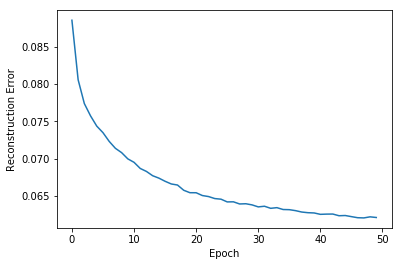

In [90]:
# Plot reconstruction errors
print("DBN")
pd.Series(error_list).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Error")
plt.show()

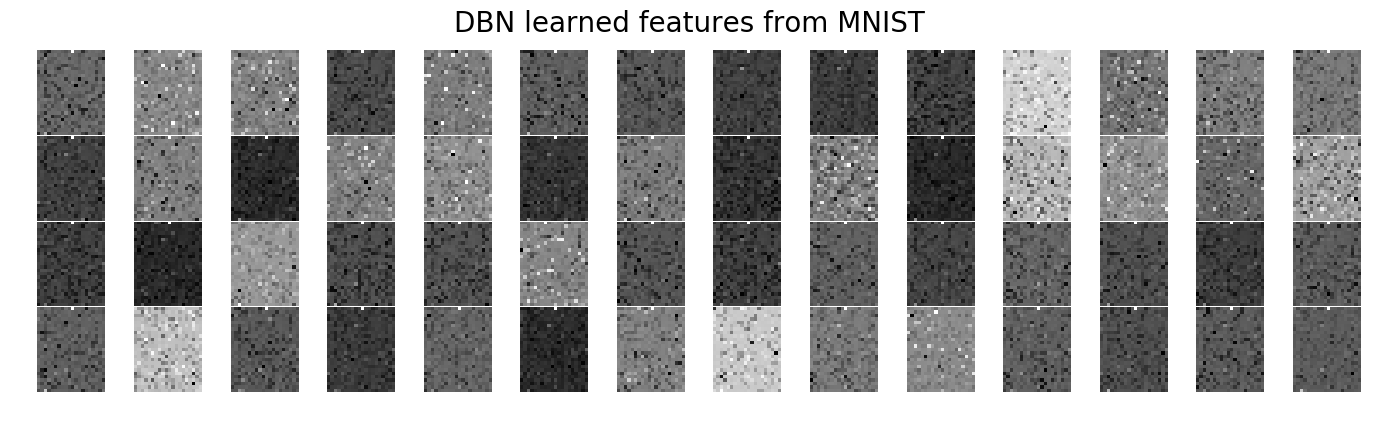

None


In [91]:
print(dbn.show_features((25,20),"DBN learned features from MNIST", 56))

In [94]:
# Generate images and store them
inputXReduced = X_train.loc[:4999]
for i in range(0,20):
    print("Run ",i)
    finalOutput_DBN, reconstructedOutput_DBN = dbn.dbn_output(inputXReduced)
    if i==0:
        generatedImages = finalOutput_DBN
    else:
        generatedImages = np.append(generatedImages, finalOutput_DBN, axis=0)

Run  0
Run  1
Run  2
Run  3
Run  4
Run  5
Run  6
Run  7
Run  8
Run  9
Run  10
Run  11
Run  12
Run  13
Run  14
Run  15
Run  16
Run  17
Run  18
Run  19


In [95]:
# Generate a vector of labels for the generated images
for i in range(0,20):
    if i==0:
        labels = y_train.loc[:4999]
    else:
        labels = np.append(labels,y_train.loc[:4999])

In [104]:
# Generate images based on the validation set
inputValidation = np.array(X_validation)
finalOutput_DBN_validation, reconstructedOutput_DBN_validation = \
    dbn.dbn_output(inputValidation)

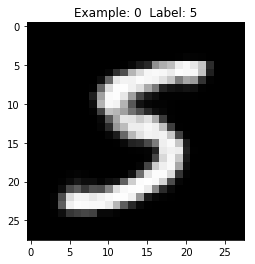

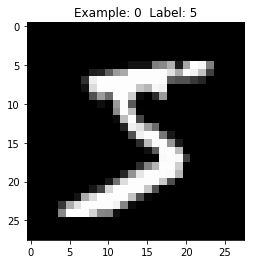

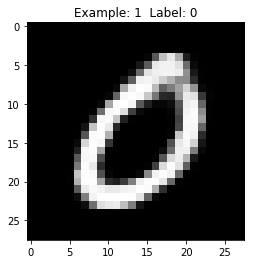

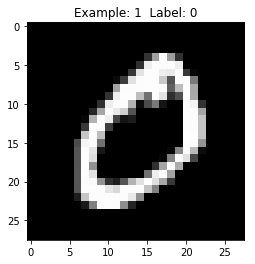

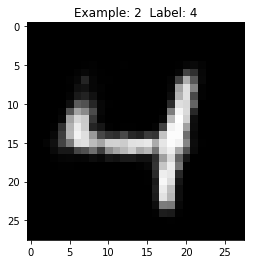

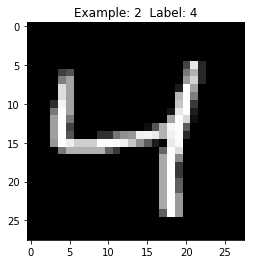

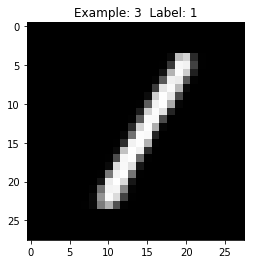

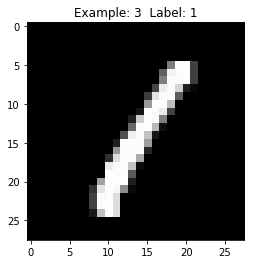

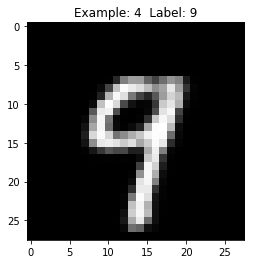

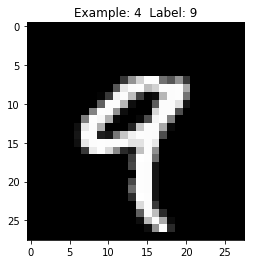

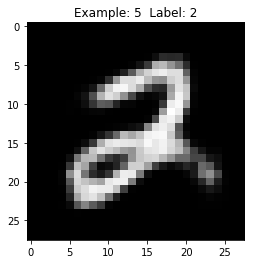

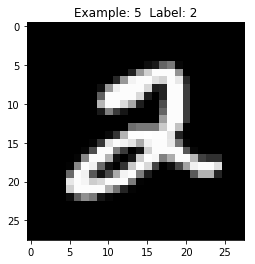

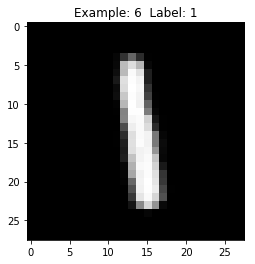

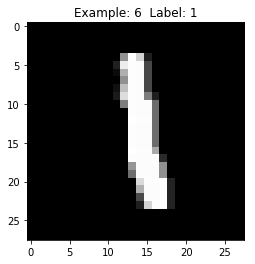

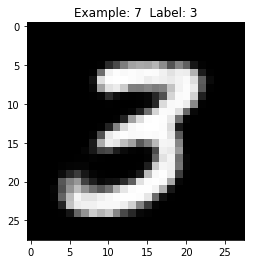

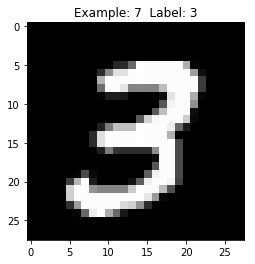

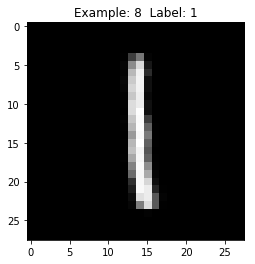

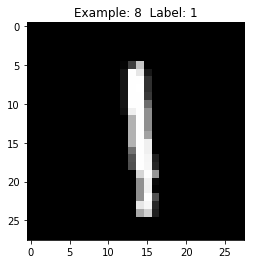

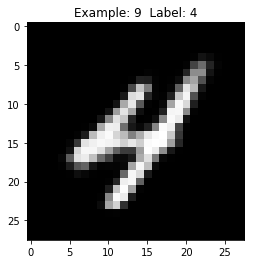

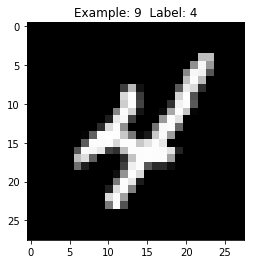

In [105]:
# View first few reconstructed images
for i in range(0,10):
    example = i
    reconstructedX = pd.DataFrame(data=reconstructedOutput_DBN, \
                                  index=X_train[0:5000].index)
    view_digit(reconstructedX, y_train, example)
    view_digit(X_train, y_train, example)

Run  0
Generated


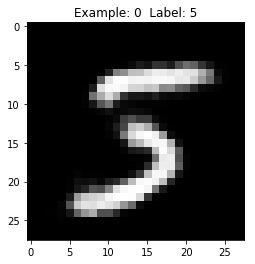

Run  1
Generated


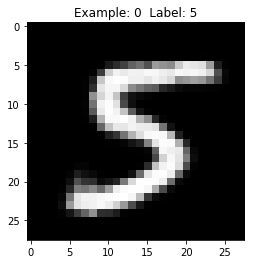

Run  2
Generated


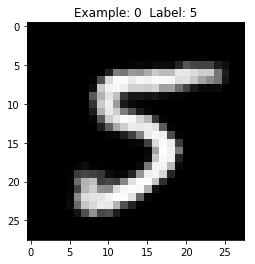

Run  3
Generated


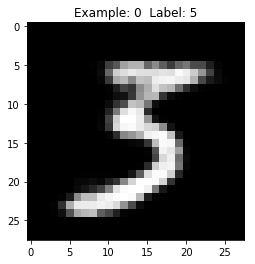

Run  4
Generated


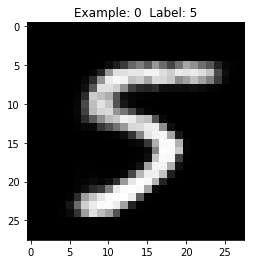

Run  5
Generated


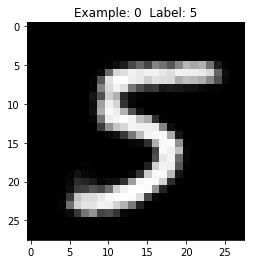

Run  6
Generated


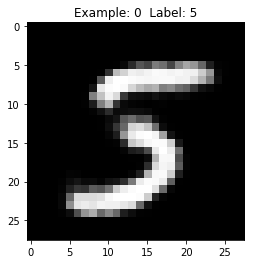

Run  7
Generated


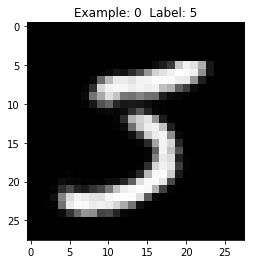

Run  8
Generated


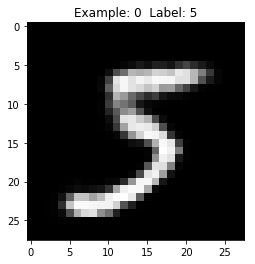

Run  9
Generated


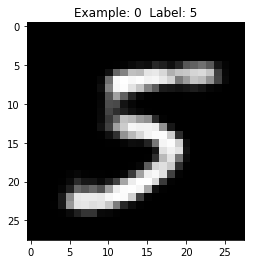

In [96]:
# Generate the first examp times
inputXReduced = X_train.loc[:0]
for i in range(0,10):
    example = 0
    print("Run ",i)
    finalOutput_DBN_fives, reconstructedOutput_DBN_fives = \
        dbn.dbn_output(inputXReduced)
    reconstructedX_fives = pd.DataFrame(data=reconstructedOutput_DBN_fives, \
                                        index=[0])
    print("Generated")
    view_digit(reconstructedX_fives, y_train.loc[:0], example)

In [ ]:
# Supervised Only

In [97]:
predictionColumns = ['0','1','2','3','4','5','6','7','8','9']

params_lightGB = {
    'task': 'train',
    'application':'binary',
    'num_class':10,
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'metric_freq':50,
    'is_training_metric':False,
    'max_depth':4,
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'bagging_freq': 0,
    'bagging_seed': 2018,
    'verbose': 0,
    'num_threads':16
}

In [98]:
trainingScore = []
validationScore = []
predictionsLightGBM = pd.DataFrame(data=[], \
                        index=y_validation.index, \
                        columns=predictionColumns)

lgb_train = lgb.Dataset(X_train.loc[:4999], y_train.loc[:4999])
lgb_eval = lgb.Dataset(X_validation, y_validation, reference=lgb_train)
gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=2000,
                   valid_sets=lgb_eval, early_stopping_rounds=200)
    
loglossTraining = log_loss(y_train.loc[:4999], \
    gbm.predict(X_train.loc[:4999], num_iteration=gbm.best_iteration))
trainingScore.append(loglossTraining)
    
predictionsLightGBM.loc[X_validation.index,predictionColumns] = \
    gbm.predict(X_validation, num_iteration=gbm.best_iteration) 
loglossValidation = log_loss(y_validation, 
    predictionsLightGBM.loc[X_validation.index,predictionColumns])
validationScore.append(loglossValidation)
    
print('Training Log Loss: ', loglossTraining)
print('Validation Log Loss: ', loglossValidation)

loglossLightGBM = log_loss(y_validation, predictionsLightGBM)
print('LightGBM Gradient Boosting Log Loss: ', loglossLightGBM)

[1]	valid_0's multi_logloss: 2.03259
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's multi_logloss: 1.83275
[3]	valid_0's multi_logloss: 1.6722
[4]	valid_0's multi_logloss: 1.54122
[5]	valid_0's multi_logloss: 1.4341
[6]	valid_0's multi_logloss: 1.33935
[7]	valid_0's multi_logloss: 1.25721
[8]	valid_0's multi_logloss: 1.18422
[9]	valid_0's multi_logloss: 1.11702
[10]	valid_0's multi_logloss: 1.05586
[11]	valid_0's multi_logloss: 0.99914
[12]	valid_0's multi_logloss: 0.947816
[13]	valid_0's multi_logloss: 0.90067
[14]	valid_0's multi_logloss: 0.858902
[15]	valid_0's multi_logloss: 0.819287
[16]	valid_0's multi_logloss: 0.784158
[17]	valid_0's multi_logloss: 0.752388
[18]	valid_0's multi_logloss: 0.722712
[19]	valid_0's multi_logloss: 0.695435
[20]	valid_0's multi_logloss: 0.669445
[21]	valid_0's multi_logloss: 0.645138
[22]	valid_0's multi_logloss: 0.621273
[23]	valid_0's multi_logloss: 0.600193
[24]	valid_0's multi_logloss: 0.580599
[25]	valid_0's multi_log

[210]	valid_0's multi_logloss: 0.19152
[211]	valid_0's multi_logloss: 0.191388
[212]	valid_0's multi_logloss: 0.191569
[213]	valid_0's multi_logloss: 0.191571
[214]	valid_0's multi_logloss: 0.191732
[215]	valid_0's multi_logloss: 0.191871
[216]	valid_0's multi_logloss: 0.191857
[217]	valid_0's multi_logloss: 0.191746
[218]	valid_0's multi_logloss: 0.191732
[219]	valid_0's multi_logloss: 0.191695
[220]	valid_0's multi_logloss: 0.191711
[221]	valid_0's multi_logloss: 0.19172
[222]	valid_0's multi_logloss: 0.191716
[223]	valid_0's multi_logloss: 0.191674
[224]	valid_0's multi_logloss: 0.191806
[225]	valid_0's multi_logloss: 0.191961
[226]	valid_0's multi_logloss: 0.192058
[227]	valid_0's multi_logloss: 0.192037
[228]	valid_0's multi_logloss: 0.191997
[229]	valid_0's multi_logloss: 0.191999
[230]	valid_0's multi_logloss: 0.191947
[231]	valid_0's multi_logloss: 0.192155
[232]	valid_0's multi_logloss: 0.192007
[233]	valid_0's multi_logloss: 0.192069
[234]	valid_0's multi_logloss: 0.192049
[2

In [102]:
predictionsLightGBM_firm = np.argmax(np.array(predictionsLightGBM), axis=1)
accuracyValidation_lightGBM = accuracy_score(np.array(y_validation), \
                                            predictionsLightGBM_firm)
print("Supervised-Only Accuracy: ", accuracyValidation_lightGBM)

Supervised-Only Accuracy:  0.9439


In [ ]:
# Unsupervised and Supervised Solution

In [106]:
# Prepare DBN-based DataFrames for LightGBM use
generatedImagesDF = pd.DataFrame(data=generatedImages,index=range(0,100000))
labelsDF = pd.DataFrame(data=labels,index=range(0,100000))

X_train_lgb = pd.DataFrame(data=generatedImagesDF,
                           index=generatedImagesDF.index)
X_validation_lgb = pd.DataFrame(data=finalOutput_DBN_validation,
                                index=X_validation.index)

In [107]:
# Train LightGBM
trainingScore = []
validationScore = []
predictionsDBN = pd.DataFrame(data=[],index=y_validation.index,
                              columns=predictionColumns)

lgb_train = lgb.Dataset(X_train_lgb, labels)
lgb_eval = lgb.Dataset(X_validation_lgb, y_validation, reference=lgb_train)
gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=2000,
                   valid_sets=lgb_eval, early_stopping_rounds=200)
    
loglossTraining = log_loss(labelsDF, gbm.predict(X_train_lgb, \
                            num_iteration=gbm.best_iteration))
trainingScore.append(loglossTraining)
    
predictionsDBN.loc[X_validation.index,predictionColumns] = \
    gbm.predict(X_validation_lgb, num_iteration=gbm.best_iteration) 
loglossValidation = log_loss(y_validation, 
    predictionsDBN.loc[X_validation.index,predictionColumns])
validationScore.append(loglossValidation)
    
print('Training Log Loss: ', loglossTraining)
print('Validation Log Loss: ', loglossValidation)

loglossDBN = log_loss(y_validation, predictionsDBN)
print('LightGBM Gradient Boosting Log Loss: ', loglossDBN)

[1]	valid_0's multi_logloss: 1.93287
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's multi_logloss: 1.69605
[3]	valid_0's multi_logloss: 1.51402
[4]	valid_0's multi_logloss: 1.36849
[5]	valid_0's multi_logloss: 1.24451
[6]	valid_0's multi_logloss: 1.14062
[7]	valid_0's multi_logloss: 1.05092
[8]	valid_0's multi_logloss: 0.973116
[9]	valid_0's multi_logloss: 0.904238
[10]	valid_0's multi_logloss: 0.841988
[11]	valid_0's multi_logloss: 0.787594
[12]	valid_0's multi_logloss: 0.737513
[13]	valid_0's multi_logloss: 0.692809
[14]	valid_0's multi_logloss: 0.652588
[15]	valid_0's multi_logloss: 0.61596
[16]	valid_0's multi_logloss: 0.582917
[17]	valid_0's multi_logloss: 0.552566
[18]	valid_0's multi_logloss: 0.524777
[19]	valid_0's multi_logloss: 0.50012
[20]	valid_0's multi_logloss: 0.476535
[21]	valid_0's multi_logloss: 0.455261
[22]	valid_0's multi_logloss: 0.435853
[23]	valid_0's multi_logloss: 0.4178
[24]	valid_0's multi_logloss: 0.401233
[25]	valid_0's multi_

[208]	valid_0's multi_logloss: 0.182243
[209]	valid_0's multi_logloss: 0.182516
[210]	valid_0's multi_logloss: 0.182791
[211]	valid_0's multi_logloss: 0.183092
[212]	valid_0's multi_logloss: 0.183353
[213]	valid_0's multi_logloss: 0.183638
[214]	valid_0's multi_logloss: 0.184047
[215]	valid_0's multi_logloss: 0.184295
[216]	valid_0's multi_logloss: 0.184595
[217]	valid_0's multi_logloss: 0.184736
[218]	valid_0's multi_logloss: 0.184931
[219]	valid_0's multi_logloss: 0.185128
[220]	valid_0's multi_logloss: 0.185457
[221]	valid_0's multi_logloss: 0.185743
[222]	valid_0's multi_logloss: 0.185878
[223]	valid_0's multi_logloss: 0.186125
[224]	valid_0's multi_logloss: 0.186349
[225]	valid_0's multi_logloss: 0.186885
[226]	valid_0's multi_logloss: 0.187195
[227]	valid_0's multi_logloss: 0.187498
[228]	valid_0's multi_logloss: 0.187709
[229]	valid_0's multi_logloss: 0.18782
[230]	valid_0's multi_logloss: 0.188202
[231]	valid_0's multi_logloss: 0.188403
[232]	valid_0's multi_logloss: 0.188714
[

In [109]:
# DBN
predictionsDBN_firm = np.argmax(np.array(predictionsDBN), axis=1)
accuracyValidation_DBN = accuracy_score(np.array(y_validation), \
                                        predictionsDBN_firm)
print("DBN-Based Solution Accuracy: ", accuracyValidation_DBN)

DBN-Based Solution Accuracy:  0.9525
